# GeoSaskatoon 2023 - Random Forest Regression Model For Investigating The Impact of Data Quantity on Model Results

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import math
import pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

from openpyxl import load_workbook

In [2]:
# get data
data = pd.read_excel('SWedge Results.xlsx',sheet_name = "Probabilistic Values", engine='openpyxl')
data.head()

,Wedge ID,Safety Factor,Wedge Volume (m3),Wedge Weight (MN),Plunge Line of Intersection (°),Trend Line of Intersection (°),Length Line of Intersection (m),Plunge Line of Intersection Basal-Joint1 (°),Trend Line of Intersection Basal-Joint1 (°),Length Line of Intersection Basal-Joint1 (m),...,Water Pressure Joint 2 (MPa),Water Pressure Basal Joint (MPa),Water Pressure Tension Crack (MPa),Ponded Water Depth (m),Seismic Alpha,Seismic Plunge (°),Seismic Trend (°),Maximum Persistence Joint 1 (m),Maximum Persistence Joint 2 (m),Maximum Persistence Basal Joint (m)
0,BFA 60 [0],1.082239,6349.248707,171.429715,31.846178,161.418240,56.856884,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1,BFA 60 [1],1.203906,7701.148241,207.931003,31.905513,168.542870,56.762278,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
2,BFA 60 [2],0.896601,2341.641868,63.224330,36.973415,150.874977,49.879923,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
3,BFA 60 [3],0.680996,155.345062,4.194317,54.969435,195.219985,36.636928,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
4,BFA 60 [4],1.263948,7468.340623,201.645197,29.688564,178.765625,60.571151,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN


In [3]:
print(np.shape(data))

(5000, 87)


In [4]:
# get data specifically for the modelling (i.e., the inputs and output)
data_model = data[["Safety Factor","Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Cohesion of Joint 1 (MPa)","Friction Angle of Joint 2 (°)","Cohesion of Joint 2 (MPa)"]]
print(np.shape(data_model))
data_model.head()

(5000, 11)


,Safety Factor,Dip of Joint 1 (°),Dip Direction of Joint 1 (°),Dip of Joint 2 (°),Dip Direction of Joint 2 (°),Dip of Slope (°),Dip Direction of Slope (°),Friction Angle of Joint 1 (°),Cohesion of Joint 1 (MPa),Friction Angle of Joint 2 (°),Cohesion of Joint 2 (MPa)
0,1.082239,39.265808,120.865923,51.646228,221.979277,58.840543,182.626968,29.567773,0,29.522638,0
1,1.203906,38.981309,128.836961,57.766382,235.428421,63.804918,181.820235,32.713619,0,29.079492,0
2,0.896601,42.032968,117.504566,62.427355,217.726775,58.134485,180.398207,29.660213,0,27.455866,0
3,0.680996,69.264568,137.906910,66.183726,246.195109,61.968796,182.439496,30.866657,0,34.401616,0
4,1.263948,46.728166,121.226945,50.803809,241.060589,60.832522,179.091174,28.789453,0,28.613525,0


In [5]:
# remove any realizations that are not kinematically possible & any duplicates
data_model =  data_model.dropna()
data_model = data_model.drop_duplicates()
print(np.shape(data_model))

(4992, 11)


## Learning curves for different train_test_split random_states without cross-validation

Constant random_state (=123) for random forest, variable random_state (=0, 1, 42, 123) for train_test_split

Note that minimal pre-processing (aka normalizing/standardizing data and removing collinear inputs) is performed because they aren't necessary for random forests

In [6]:
num_samples = []
R2_train_subsample_list = []
rmse_train_subsample_list = []
mape_train_subsample_list = []
R2_test_subsample_list = []
rmse_test_subsample_list = []
mape_test_subsample_list = []

random_state_val = [0,1,42,123]

for x in range(0,4):

    for i in range(100, 5000, 50):

        num_samples.append(i)

        # get subsample of data
        data_subsample = data_model.sample(n = i,random_state = 1)

        train_subsample, test_subsample = train_test_split(data_subsample, test_size=0.2, random_state=random_state_val[x])

        x_train_subsample = train_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Cohesion of Joint 1 (MPa)","Friction Angle of Joint 2 (°)","Cohesion of Joint 2 (MPa)"]]
        y_train_subsample = train_subsample[["Safety Factor"]]
        y_train_subsample = np.ravel(y_train_subsample)
        
        x_test_subsample = test_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Cohesion of Joint 1 (MPa)","Friction Angle of Joint 2 (°)","Cohesion of Joint 2 (MPa)"]]
        y_test_subsample = test_subsample[["Safety Factor"]]
        y_test_subsample = np.ravel(y_test_subsample)

        # train RF model
        rf_subsample = RandomForestRegressor(random_state = 123)
        model_subsample = rf_subsample.fit(x_train_subsample,y_train_subsample)
        ypred_RF_subsample = rf_subsample.predict(x_train_subsample)
        #ypred_RF_subsample = np.reshape(ypred_RF_subsample,(len(ypred_RF_subsample),1))

        R2_train_subsample = rf_subsample.score(x_train_subsample,y_train_subsample)
        rmse_train_subsample = math.sqrt(mean_squared_error(y_train_subsample,ypred_RF_subsample))
        mape_train_subsample = mean_absolute_percentage_error(y_train_subsample,ypred_RF_subsample)

        # append training R2, rmse, and mape to their respective lists
        R2_train_subsample_list.append(R2_train_subsample)
        rmse_train_subsample_list.append(rmse_train_subsample)
        mape_train_subsample_list.append(mape_train_subsample)

        # testing the RF model
        # predict y_test and find RMSE
        ypred_test_RF_subsample = rf_subsample.predict(x_test_subsample)
        #ypred_test_RF_subsample = np.reshape(ypred_test_RF_subsample,(len(ypred_test_RF_subsample),1))

        rmse_test_subsample = math.sqrt(mean_squared_error(y_test_subsample,ypred_test_RF_subsample))
        R2_test_subsample = rf_subsample.score(x_test_subsample,y_test_subsample)
        mape_test_subsample = mean_absolute_percentage_error(y_test_subsample,ypred_test_RF_subsample)

        # append testing R2, rmse, and mape to their respective lists
        R2_test_subsample_list.append(R2_test_subsample)
        rmse_test_subsample_list.append(rmse_test_subsample)
        mape_test_subsample_list.append(mape_test_subsample)


In [7]:
# convert the lists into dataframes
num_samples = pd.DataFrame(num_samples)
R2_train_subsample_list = pd.DataFrame(R2_train_subsample_list)
rmse_train_subsample_list = pd.DataFrame(rmse_train_subsample_list)
mape_train_subsample_list = pd.DataFrame(mape_train_subsample_list)
R2_test_subsample_list = pd.DataFrame(R2_test_subsample_list)
rmse_test_subsample_list = pd.DataFrame(rmse_test_subsample_list)
mape_test_subsample_list = pd.DataFrame(mape_test_subsample_list)

In [8]:
# concatenate the dataframes together
rslts = pd.concat([num_samples,R2_train_subsample_list,rmse_train_subsample_list,mape_train_subsample_list,R2_test_subsample_list,rmse_test_subsample_list,mape_test_subsample_list],axis=1)

In [9]:
# get the results for each random_state value
random_state_len = int(max(np.shape(rslts))/len(random_state_val))
randomstate0_rslts = rslts[0:random_state_len]
randomstate1_rslts = rslts[random_state_len:2*random_state_len]
randomstate42_rslts = rslts[2*random_state_len:3*random_state_len]
randomstate123_rslts = rslts[3*random_state_len:4*random_state_len]

randomstate123_rslts.tail()

,0,0,0,0,0,0,0
387,4750,0.986123,0.062352,0.019340,0.941865,0.112784,0.049802
388,4800,0.988130,0.058480,0.019277,0.950955,0.093783,0.049615
389,4850,0.984687,0.064669,0.019405,0.900580,0.156027,0.050626
390,4900,0.980187,0.071825,0.019265,0.857705,0.202752,0.049849
391,4950,0.980488,0.072824,0.019094,0.918750,0.138461,0.050719


In [10]:
# format the results for each random_state value
randomstate0_rslts_np = np.asarray(randomstate0_rslts)
randomstate1_rslts_np = np.asarray(randomstate1_rslts)
randomstate42_rslts_np = np.asarray(randomstate42_rslts)
randomstate123_rslts_np = np.asarray(randomstate123_rslts)


randomstate0_rslts_pd = pd.DataFrame(randomstate0_rslts_np,columns=['num_samples','R2_train_subsample','rmse_train_subsample','mape_train_subsample','R2_test_subsample','rmse_test_subsample','mape_test_subsample'])
randomstate1_rslts_pd = pd.DataFrame(randomstate1_rslts_np,columns=['num_samples','R2_train_subsample','rmse_train_subsample','mape_train_subsample','R2_test_subsample','rmse_test_subsample','mape_test_subsample'])
randomstate42_rslts_pd = pd.DataFrame(randomstate42_rslts_np,columns=['num_samples','R2_train_subsample','rmse_train_subsample','mape_train_subsample','R2_test_subsample','rmse_test_subsample','mape_test_subsample'])
randomstate123_rslts_pd = pd.DataFrame(randomstate123_rslts_np,columns=['num_samples','R2_train_subsample','rmse_train_subsample','mape_train_subsample','R2_test_subsample','rmse_test_subsample','mape_test_subsample'])


In [11]:
randomstate123_rslts_pd.tail()

,num_samples,R2_train_subsample,rmse_train_subsample,mape_train_subsample,R2_test_subsample,rmse_test_subsample,mape_test_subsample
93,4750.0,0.986123,0.062352,0.019340,0.941865,0.112784,0.049802
94,4800.0,0.988130,0.058480,0.019277,0.950955,0.093783,0.049615
95,4850.0,0.984687,0.064669,0.019405,0.900580,0.156027,0.050626
96,4900.0,0.980187,0.071825,0.019265,0.857705,0.202752,0.049849
97,4950.0,0.980488,0.072824,0.019094,0.918750,0.138461,0.050719


([<matplotlib.axis.XTick at 0x274bd8832e0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

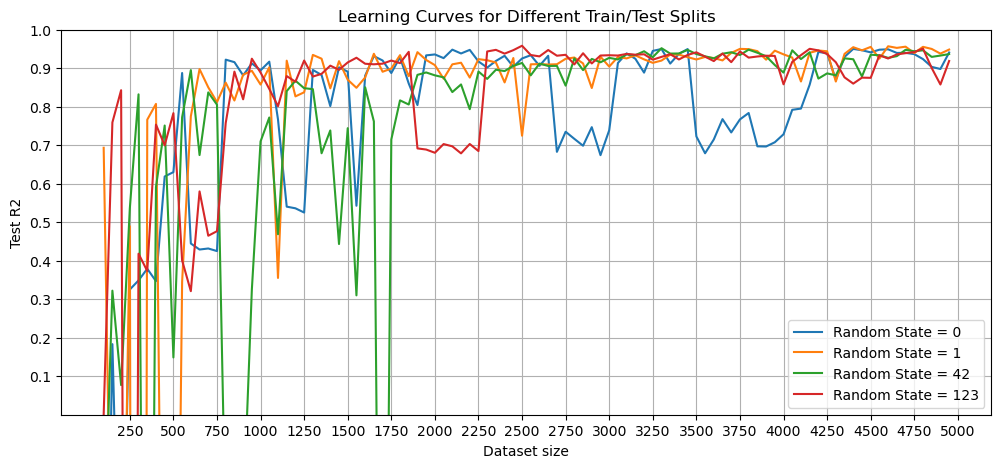

In [12]:
# plot learning curves for different train/test splits for test R2
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rslts_pd['R2_test_subsample'],label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rslts_pd['R2_test_subsample'],label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rslts_pd['R2_test_subsample'],label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rslts_pd['R2_test_subsample'],label='Random State = 123')
plt.title('Learning Curves for Different Train/Test Splits')
plt.xlabel('Dataset size')
plt.ylabel('Test R2')
plt.legend()
plt.grid()
plt.ylim(0,1)
plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

([<matplotlib.axis.XTick at 0x274c26f4d60>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

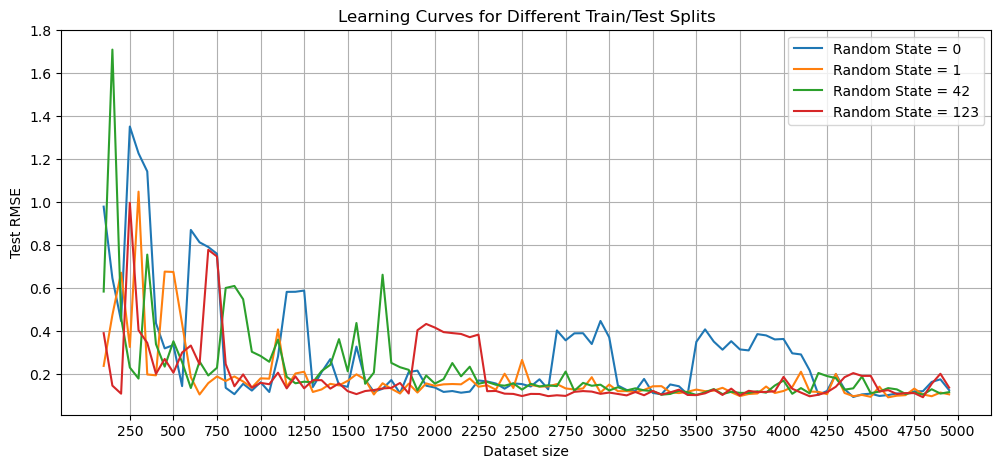

In [13]:
# plot learning curves for different train/test splits for test rmse
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rslts_pd['rmse_test_subsample'],label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rslts_pd['rmse_test_subsample'],label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rslts_pd['rmse_test_subsample'],label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rslts_pd['rmse_test_subsample'],label='Random State = 123')
plt.title('Learning Curves for Different Train/Test Splits')
plt.xlabel('Dataset size')
plt.ylabel('Test RMSE')
plt.legend()
plt.grid()
plt.yticks(ticks=[0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

In [14]:
# calculate the difference in train and test R2 and RMSE to determine areas of overfitting/underfitting/unreliable models
# train R2 - test R2
randomstate0_R2diff = randomstate0_rslts_pd['R2_train_subsample'] - randomstate0_rslts_pd['R2_test_subsample']
randomstate1_R2diff = randomstate1_rslts_pd['R2_train_subsample'] - randomstate1_rslts_pd['R2_test_subsample']
randomstate42_R2diff = randomstate42_rslts_pd['R2_train_subsample'] - randomstate42_rslts_pd['R2_test_subsample']
randomstate123_R2diff = randomstate123_rslts_pd['R2_train_subsample'] - randomstate123_rslts_pd['R2_test_subsample']

# test RMSE - train RMSE
randomstate0_rmsediff = randomstate0_rslts_pd['rmse_test_subsample'] - randomstate0_rslts_pd['rmse_train_subsample']
randomstate1_rmsediff = randomstate1_rslts_pd['rmse_test_subsample'] - randomstate1_rslts_pd['rmse_train_subsample']
randomstate42_rmsediff = randomstate42_rslts_pd['rmse_test_subsample'] - randomstate42_rslts_pd['rmse_train_subsample']
randomstate123_rmsediff = randomstate123_rslts_pd['rmse_test_subsample'] - randomstate123_rslts_pd['rmse_train_subsample']

([<matplotlib.axis.XTick at 0x274c27a5a60>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

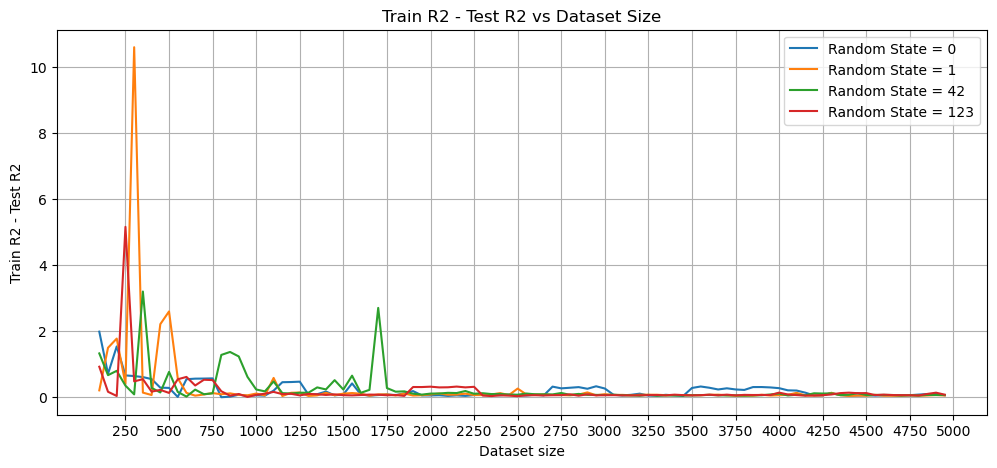

In [15]:
# plot R2 difference vs dataset size
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_R2diff,label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_R2diff,label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_R2diff,label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_R2diff,label='Random State = 123')
plt.title('Train R2 - Test R2 vs Dataset Size')
plt.xlabel('Dataset size')
plt.ylabel('Train R2 - Test R2')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

([<matplotlib.axis.XTick at 0x274c271a9d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

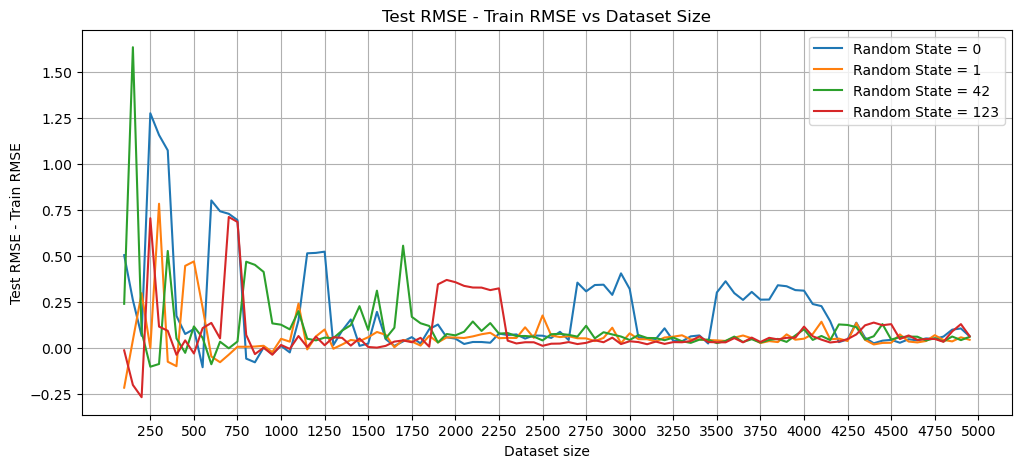

In [16]:
# plot rmse difference vs dataset size
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rmsediff,label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rmsediff,label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rmsediff,label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rmsediff,label='Random State = 123')
plt.title('Test RMSE - Train RMSE vs Dataset Size')
plt.xlabel('Dataset size')
plt.ylabel('Test RMSE - Train RMSE')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

In [17]:
rslts_formatted = pd.concat([randomstate0_rslts_pd,randomstate1_rslts_pd,randomstate42_rslts_pd,randomstate123_rslts_pd],axis=1)
rslts_formatted

,num_samples,R2_train_subsample,rmse_train_subsample,mape_train_subsample,R2_test_subsample,rmse_test_subsample,mape_test_subsample,num_samples,R2_train_subsample,rmse_train_subsample,...,R2_test_subsample,rmse_test_subsample,mape_test_subsample,num_samples,R2_train_subsample,rmse_train_subsample,mape_train_subsample,R2_test_subsample,rmse_test_subsample,mape_test_subsample
0,100.0,0.870793,0.473666,0.062139,-1.103299,0.978598,0.349937,100.0,0.886248,0.452827,...,-0.380175,0.584331,0.208801,100.0,0.910613,0.402558,0.074990,0.000578,0.391145,0.165411
1,150.0,0.877634,0.385651,0.058479,0.183321,0.646797,0.203484,150.0,0.858221,0.430775,...,0.322214,1.707680,0.138396,150.0,0.908751,0.346636,0.060595,0.759202,0.147615,0.081519
2,200.0,0.861586,0.380095,0.056424,-0.665431,0.447563,0.174179,200.0,0.862578,0.373311,...,0.076947,0.462184,0.172041,200.0,0.865186,0.375768,0.059178,0.842857,0.110263,0.087274
3,250.0,0.972191,0.075999,0.042165,0.325220,1.350620,0.111203,250.0,0.874320,0.325636,...,0.535990,0.231754,0.132641,250.0,0.900187,0.291134,0.052768,-4.255647,0.996413,0.194124
4,300.0,0.975287,0.069604,0.038496,0.348799,1.226098,0.139360,300.0,0.906868,0.264354,...,0.832133,0.180322,0.114808,300.0,0.883565,0.287189,0.051984,0.418268,0.404750,0.117558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,4750.0,0.982634,0.069461,0.019796,0.936594,0.120268,0.050964,4750.0,0.984887,0.062813,...,0.944042,0.115645,0.050454,4750.0,0.986123,0.062352,0.019340,0.941865,0.112784,0.049802
94,4800.0,0.988051,0.058306,0.019202,0.923726,0.121825,0.052452,4800.0,0.985944,0.061518,...,0.946497,0.105827,0.049858,4800.0,0.988130,0.058480,0.019277,0.950955,0.093783,0.049615
95,4850.0,0.984529,0.063915,0.019637,0.903479,0.164826,0.051049,4850.0,0.986936,0.061110,...,0.929408,0.130829,0.054316,4850.0,0.984687,0.064669,0.019405,0.900580,0.156027,0.050626
96,4900.0,0.981244,0.069276,0.019488,0.897960,0.176786,0.051913,4900.0,0.988807,0.055889,...,0.932883,0.110656,0.050435,4900.0,0.980187,0.071825,0.019265,0.857705,0.202752,0.049849


In [18]:
print(np.shape(rslts))

(392, 7)


In [19]:
# output results Excel
book = load_workbook('GeoSaskatoon 2023 ML Results.xlsx')
writer = pd.ExcelWriter('GeoSaskatoon 2023 ML Results.xlsx', engine='openpyxl') 
writer.book = book
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
rslts_formatted.to_excel(writer, 'ML OUTPUT')
writer.save()
writer.close()

In [20]:
# double check 
data_subsample = data_model.sample(n = 400,random_state = 1)

train_subsample, test_subsample = train_test_split(data_subsample, test_size=0.2, random_state= 42)

x_train_subsample = train_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Cohesion of Joint 1 (MPa)","Friction Angle of Joint 2 (°)","Cohesion of Joint 2 (MPa)"]]
y_train_subsample = train_subsample[["Safety Factor"]]

x_test_subsample = test_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Cohesion of Joint 1 (MPa)","Friction Angle of Joint 2 (°)","Cohesion of Joint 2 (MPa)"]]
y_test_subsample = test_subsample[["Safety Factor"]]

# train RF model
rf_subsample = RandomForestRegressor(random_state = 123)
model_subsample = rf_subsample.fit(x_train_subsample,y_train_subsample)
ypred_RF_subsample = rf_subsample.predict(x_train_subsample)

# testing the RF model
# predict y_test and find RMSE
ypred_test_RF_subsample = rf_subsample.predict(x_test_subsample)
#ypred_test_RF_subsample = np.reshape(ypred_test_RF_subsample,(len(ypred_test_RF_subsample),1))

rmse_test_subsample = math.sqrt(mean_squared_error(y_test_subsample,ypred_test_RF_subsample))
R2_test_subsample = rf_subsample.score(x_test_subsample,y_test_subsample)
mape_test_subsample = mean_absolute_percentage_error(y_test_subsample,ypred_test_RF_subsample)

print(R2_test_subsample)
print(rmse_test_subsample)

0.5913594285870167
0.3400924364443325


C:\Users\bever\AppData\Local\Temp\ipykernel_12408\1584488808.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_subsample = rf_subsample.fit(x_train_subsample,y_train_subsample)
